In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

import random
from random import seed
from random import random

import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [2]:
from tslearn.metrics import dtw as dtw_metric

# https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

# Read Training Set Labels

In [3]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
1849


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Read the Data

In [4]:
VI_idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/"

In [5]:
file_names = ["regular_Walla2015_EVI_JFD.csv", "regular_AdamBenton2016_EVI_JFD.csv", 
              "regular_Grant2017_EVI_JFD.csv", "regular_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.049624
1,135073_WSDA_SF_2015,2015-01-20,0.026503


In [6]:
ground_truth = data[data.ID.isin(list(ground_truth_labels.ID.unique()))].copy()

# Sort the order of time-series and experts' labels identically

In [7]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100048_WSDA_SF_2017
100048_WSDA_SF_2017
____________________________________
99909_WSDA_SF_2017
99909_WSDA_SF_2017
____________________________________
True


In [8]:
mins = ground_truth.groupby("ID")[VI_idx].min()
maxs = ground_truth.groupby("ID")[VI_idx].max()
_ranges = maxs-mins
_ranges = pd.DataFrame(_ranges)
_ranges.reset_index(inplace=True)

mins = pd.DataFrame(mins)
mins.reset_index(inplace=True)


_ranges.rename(columns = {'EVI':'EVI_range'}, inplace = True)
mins.rename(columns = {'EVI':'EVI_min'}, inplace = True)

_ranges.head(2)

,ID,EVI_range
0,100048_WSDA_SF_2017,0.602470
1,100081_WSDA_SF_2017,0.721754


In [9]:
ground_truth = pd.merge(ground_truth, _ranges, on=['ID'], how='left')
ground_truth = pd.merge(ground_truth, mins, on=['ID'], how='left')
ground_truth["EVI_ratio"] = (ground_truth["EVI"]-ground_truth["EVI_min"])/ground_truth["EVI_range"]
ground_truth.head(2)

,ID,human_system_start_time,EVI,EVI_range,EVI_min,EVI_ratio
0,100048_WSDA_SF_2017,2017-01-06,0.0,0.60247,0.0,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0,0.60247,0.0,0.0


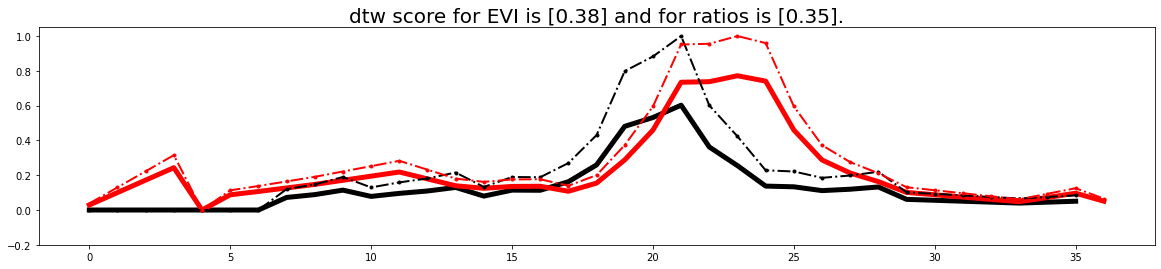

In [12]:
ID_1=ground_truth.ID.unique()[0]
ID_2=ground_truth.ID.unique()[12]

# _minimum = ground_truth[ground_truth.ID==ID_1].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_1].EVI.values.max()-_minimum
# y_1 = (ground_truth[ground_truth.ID==ID_1].EVI.values-_minimum)/_range
# _minimum = ground_truth[ground_truth.ID==ID_2].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_2].EVI.values.max()-_minimum
# y_2 = (ground_truth[ground_truth.ID==ID_2].EVI.values-_minimum)/_range

dtw_score = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI.values, 
                ground_truth[ground_truth.ID==ID_2].EVI.values)

dtw_score_ratios = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI_ratio.values, 
                       ground_truth[ground_truth.ID==ID_2].EVI_ratio.values)

# print ("dtw score is {:.2f}.".format(dtw_score))
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

# plot EVIs
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_1].EVI.values,
        c='k', linewidth=5);

plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_2].EVI.values,
        c='red', linewidth=5);

# plot ratios
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_1].EVI_ratio.values,
         ".-.", c='k', linewidth=2, label="ratios");

plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_2].EVI_ratio.values,
         ".-.", c='red', linewidth=2, label="ratios");

title = "dtw score for EVI is [{:.2f}] and for ratios is [{:.2f}].".format(dtw_score, dtw_score_ratios)
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize = 20);

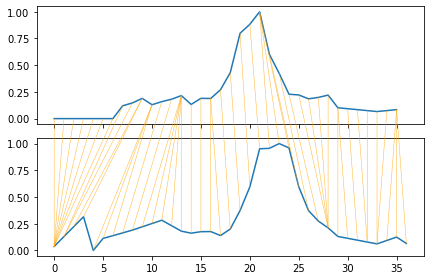

In [13]:
s1=ground_truth[ground_truth.ID==ID_1].EVI_ratio.values
s2=ground_truth[ground_truth.ID==ID_2].EVI_ratio.values
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
distance = dtw.distance(s1, s2)

In [14]:
# d, paths = dtw.warping_paths(s1, s2, window=10, use_pruning=True);
# best_path = dtw.best_path(paths);
# dtwvis.plot_warpingpaths(s1, s2, paths, best_path);

# Widen Ground Truth Table

In [15]:
EVI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]

In [16]:
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072227,0.088491,...,0.111507,0.119534,0.13248,0.061173,0.055843,0.050513,0.045183,0.039854,0.045165,0.050476
1,100081_WSDA_SF_2017,0.014832,0.167038,0.319244,0.47145,0.378153,0.284855,0.198468,0.290683,0.398445,...,0.096717,0.117915,0.159058,0.121182,0.060591,0.0,0.050004,0.100009,0.102269,0.104529


# Split Train and Test Set

#### Make sure rows of ```ground_truth_allBands``` and ```ground_truth_labels``` are in the same order

In [17]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [18]:
ground_truth.head(2)

,ID,human_system_start_time,EVI,EVI_range,EVI_min,EVI_ratio
0,100048_WSDA_SF_2017,2017-01-06,0.0,0.60247,0.0,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0,0.60247,0.0,0.0


In [19]:
ground_truth_labels = ground_truth_labels.set_index('ID')
ground_truth_labels = ground_truth_labels.reindex(index=ground_truth_wide['ID'])
ground_truth_labels = ground_truth_labels.reset_index()

In [20]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [21]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

# Start SVM

# Definitions

  - **Precision** Of all instances we predict $\hat y = 1$, what fraction is actually 1.
     \begin{equation}\label{eq:precision}
        \text{Precision} = \frac{TP}{TP + FP}
     \end{equation}

  - **Recall** Of all instances that are actually $y = 1$, what fraction we predict 1.
     \begin{equation}\label{eq:recall}
         \text{Recall} = \text{TPR} = \frac{TP}{TP + FN}
     \end{equation}
     
  - **Specifity** Fraction of all negative instances that are incorrectly predicted positive.
     \begin{equation}\label{eq:specifity}
        \text{Specifity} = \text{FPR} = \frac{FP}{TN + FP}\\
     \end{equation}
     
  - **F-Score** Adjust $\beta$ for trade off between  precision and recall. For precision oriented task $\beta = 0.5$.
     \begin{equation}\label{eq:Fscore}
        F_\beta = \frac{(1+\beta^2) TP}{ (1+\beta^2) TP + \beta^2 FN + FP}
     \end{equation}



In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [23]:
def DTW_prune(ts1, ts2):
    d,_ = dtw.warping_paths(ts1, ts2, window=10, use_pruning=True);
    return d

In [65]:
parameters = {'C':[5, 10, 13, 14, 15, 16, 17, 20, 40, 80],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'] # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
              } # , 
SVM_classifier_balanced_00 = GridSearchCV(SVC(random_state=0, class_weight='balanced'), 
                                 parameters, cv=5, verbose=1)

SVM_classifier_balanced_00.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

print (SVM_classifier_balanced_00.best_params_)
print (SVM_classifier_balanced_00.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 5, 'kernel': 'rbf'}
0.9716147503435639


In [66]:
parameters = {'C':[5, 10, 13, 14, 15, 16, 17, 20, 40, 80],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'] # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
              } # , 
SVM_classifier_NoneWeight_00 = GridSearchCV(SVC(random_state=0), 
                                 parameters, cv=5, verbose=1)

SVM_classifier_NoneWeight_00.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

print (SVM_classifier_NoneWeight_00.best_params_)
print (SVM_classifier_NoneWeight_00.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 14, 'kernel': 'rbf'}
0.9736371965185524


In [68]:
SVM_classifier_NoneWeight_00_predictions = SVM_classifier_NoneWeight_00.predict(x_test_df.iloc[:, 1:])
SVM_classifier_balanced_00_predictions = SVM_classifier_balanced_00.predict(x_test_df.iloc[:, 1:])

In [70]:
balanced_y_test_df=y_test_df.copy()
None_y_test_df=y_test_df.copy()
balanced_y_test_df["prediction"] = list(SVM_classifier_balanced_00_predictions)
balanced_y_test_df.head(2)

,ID,Vote,prediction
1612,58690_WSDA_SF_2016,1,1
1690,6714_WSDA_SF_2016,1,1


In [71]:
None_y_test_df=y_test_df.copy()
None_y_test_df=y_test_df.copy()
None_y_test_df["prediction"] = list(SVM_classifier_NoneWeight_00_predictions)
None_y_test_df.head(2)

,ID,Vote,prediction
1612,58690_WSDA_SF_2016,1,1
1690,6714_WSDA_SF_2016,1,1


In [74]:
# Balanced Confusion Table

true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

for index in balanced_y_test_df.index:
    curr_vote=list(balanced_y_test_df[balanced_y_test_df.index==index].Vote)[0]
    curr_predict=list(balanced_y_test_df[balanced_y_test_df.index==index].prediction)[0]
    if curr_vote==curr_predict:
        if curr_vote==1: 
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
        else:
            true_double_predicted_single+=1
            
balanced_confus_tbl_test = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
balanced_confus_tbl_test.loc[0, 'None'] = 'Actual_Single'
balanced_confus_tbl_test.loc[1, 'None'] = 'Actual_Double'
balanced_confus_tbl_test['Predict_Single']=0
balanced_confus_tbl_test['Predict_Double']=0

balanced_confus_tbl_test.loc[0, "Predict_Single"]=true_single_predicted_single
balanced_confus_tbl_test.loc[0, "Predict_Double"]=true_single_predicted_double
balanced_confus_tbl_test.loc[1, "Predict_Single"]=true_double_predicted_single
balanced_confus_tbl_test.loc[1, "Predict_Double"]=true_double_predicted_double
balanced_confus_tbl_test

,None,Predict_Single,Predict_Double
0,Actual_Single,302,10
1,Actual_Double,5,53


In [75]:
# None Weight Confusion Table

true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

for index in None_y_test_df.index:
    curr_vote=list(None_y_test_df[None_y_test_df.index==index].Vote)[0]
    curr_predict=list(None_y_test_df[None_y_test_df.index==index].prediction)[0]
    if curr_vote==curr_predict:
        if curr_vote==1: 
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
        else:
            true_double_predicted_single+=1
            
None_confus_tbl_test = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
None_confus_tbl_test.loc[0, 'None'] = 'Actual_Single'
None_confus_tbl_test.loc[1, 'None'] = 'Actual_Double'
None_confus_tbl_test['Predict_Single']=0
None_confus_tbl_test['Predict_Double']=0

None_confus_tbl_test.loc[0, "Predict_Single"]=true_single_predicted_single
None_confus_tbl_test.loc[0, "Predict_Double"]=true_single_predicted_double
None_confus_tbl_test.loc[1, "Predict_Single"]=true_double_predicted_single
None_confus_tbl_test.loc[1, "Predict_Double"]=true_double_predicted_double
None_confus_tbl_test

,None,Predict_Single,Predict_Double
0,Actual_Single,305,7
1,Actual_Double,7,51


In [80]:
print(classification_report(y_test_df.Vote, SVM_classifier_NoneWeight_00_predictions))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98       312
           2       0.88      0.88      0.88        58

    accuracy                           0.96       370
   macro avg       0.93      0.93      0.93       370
weighted avg       0.96      0.96      0.96       370



In [81]:
print(classification_report(y_test_df.Vote, SVM_classifier_balanced_00_predictions))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       312
           2       0.84      0.91      0.88        58

    accuracy                           0.96       370
   macro avg       0.91      0.94      0.93       370
weighted avg       0.96      0.96      0.96       370



In [78]:
import pickle
model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
filename = model_dir + 'SVM_classifier_balanced_00.sav'
pickle.dump(SVM_classifier_balanced_00, open(filename, 'wb'))

In [79]:
filename = model_dir + 'SVM_classifier_NoneWeight_00.sav'
pickle.dump(SVM_classifier_NoneWeight_00, open(filename, 'wb'))